In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

Data Set Information:

The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background).

Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions.

The data set was generated by a Monte Carlo program, Corsika, described in:
D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers,
Forschungszentrum Karlsruhe FZKA 6019 (1998).
[Web Link]

In [309]:
cols=['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','class']
df = pd.read_csv("magic04.data", names=cols)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [310]:
df["class"].unique()

array(['g', 'h'], dtype=object)

We can see we have 2 main types of classes: g(gammas) and g(hadrons). But since computers are better at understanding numbers than letters we will convert these two classes to numbers (0,1) by converting them into integers: 

In [311]:
df["class"] = df["class"].map({"g":1, "h":0})

If we run the code that gives us the array of our unique classes again we now see that these are now composed of zeros and ones: 

In [312]:
df["class"].unique()

array([1, 0])

In [313]:
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


What we can do next is, for each data feature (represented in the for loop with "label") plot a histogram that will allow us to quickly visualize our data and see if there are any obvious correlations between certain range of values of our features and the particle class. 

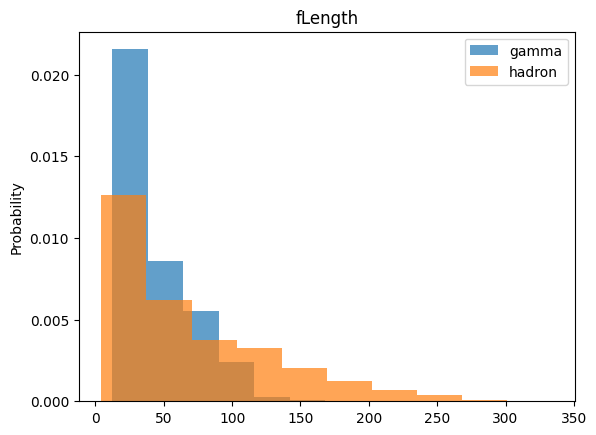

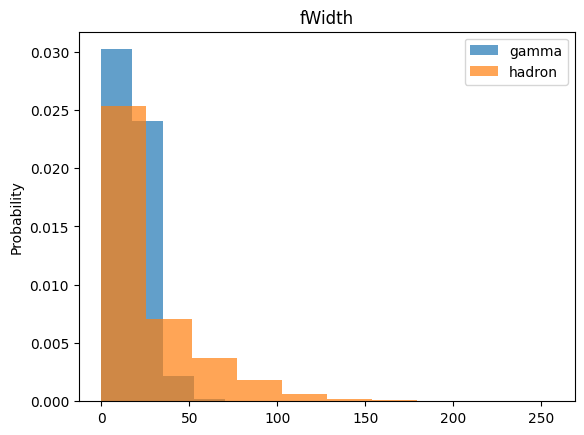

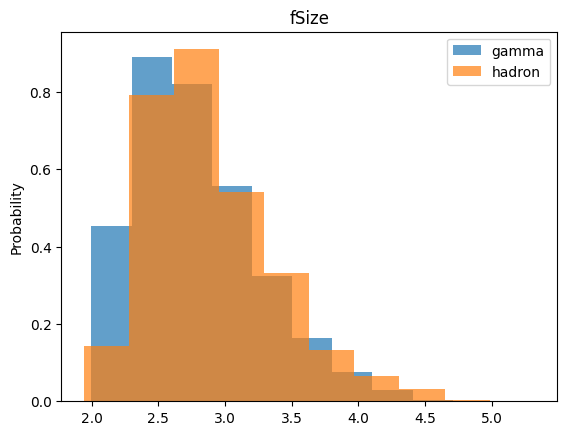

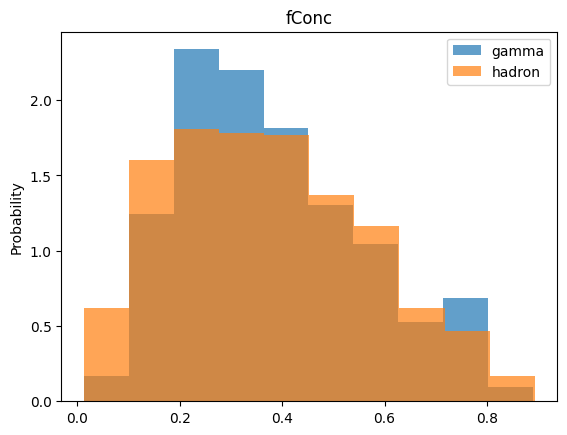

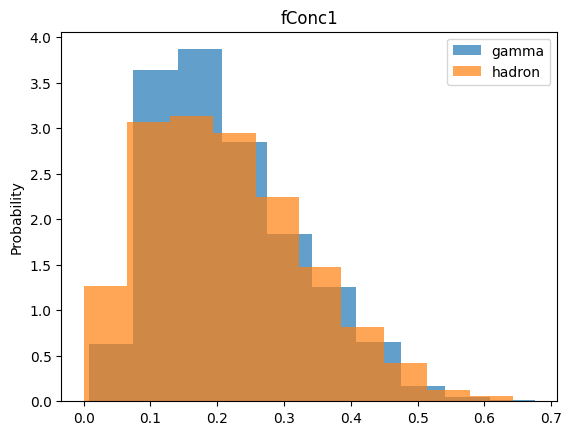

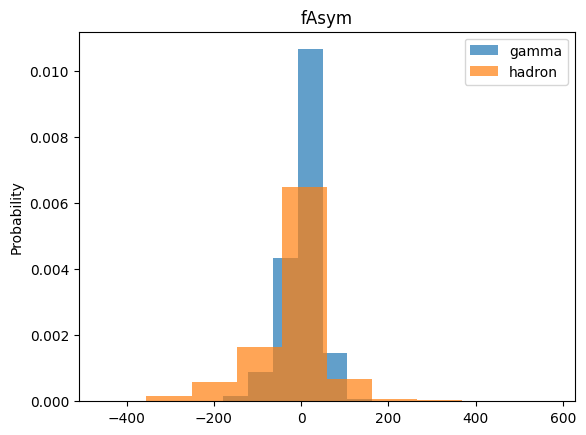

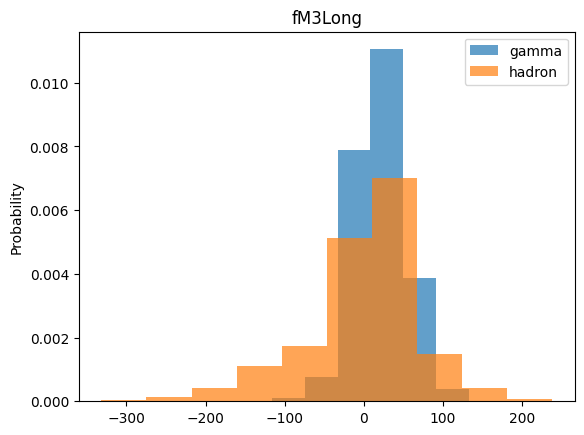

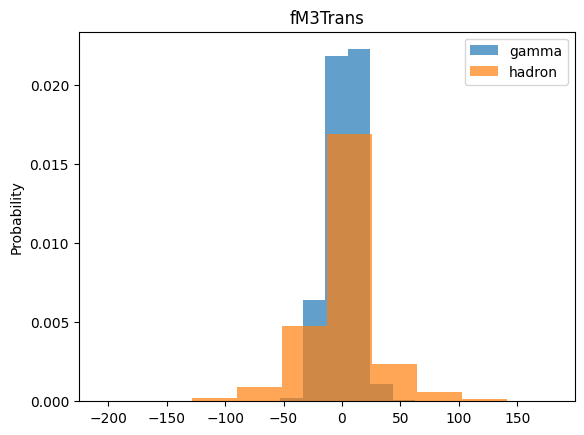

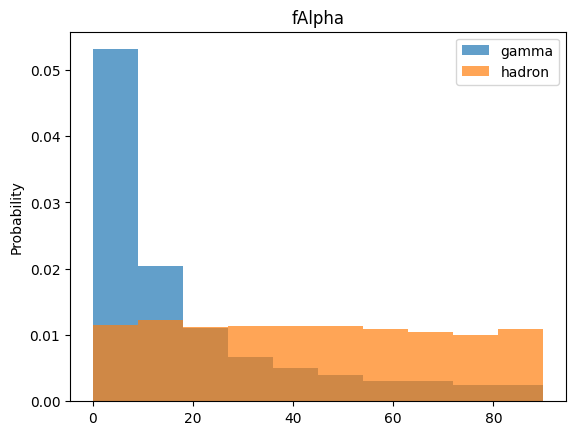

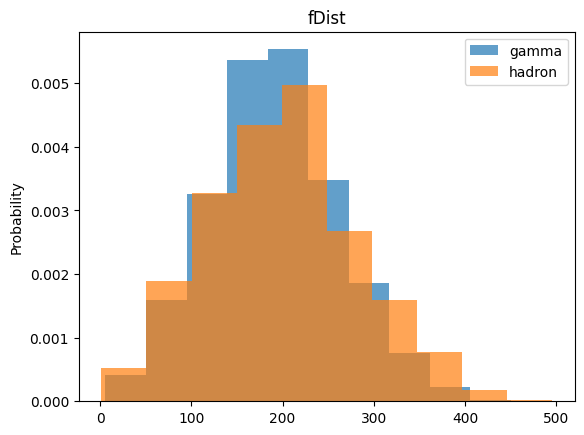

In [314]:
for label in cols[:-1]:
    plt.hist(df[df["class"]==1][label], alpha=0.7, label="gamma", density=True)
    plt.hist(df[df["class"]==0][label], alpha=0.7, label="hadron", density=True)
    plt.title(label)
    plt.ylabel("Probability")
    plt.legend()
    plt.show()


Next we are going to build our train, validation and test sets. We will use 60% of our data for training, 20% for validation and 20% for testing.

In [315]:
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.2*len(df))])

If we look at the different scales of our features we can see that they are not all on the same scale. This can be problematic for our model since it will be difficult for it to learn the weights of the different features. 

Optimization algorithms are used to train machine learning models by finding the set of weights that minimize the error of the model on the training data. These algorithms use mathematical techniques to iteratively adjust the weights in order to minimize the error.

Optimization algorithms are sensitive to the scale of the features because the error function used to evaluate the model's performance is often based on the difference between the predicted values and the true values. If the scales of the features are significantly different, then the error function may be dominated by the features with larger scales, even if those features are not as important for predicting the target variable. Since higher scale features will have larger absolute differences between the predicted values and the true values. 

For example, consider a model that is trying to predict the price of a house based on the size of the house (measured in square feet) and the number of bedrooms. If the size of the house is measured in the thousands of square feet, but the number of bedrooms is only measured in the single digits, then the scale of the "size" feature will be much larger than the scale of the "bedrooms" feature. As a result, the error function may be dominated by the "size" feature, even if the "bedrooms" feature is actually more important for predicting the price of the house.

This can lead to suboptimal model performance, because the model is weighting the features incorrectly. In order to address this issue, it is often helpful to scale the features so that they are on a similar scale before training the model. This can be done using techniques such as min-max scaling or standardization. Scaling the features can help the model to more accurately estimate the relative importance of the different features, which can improve model performance.

To do this from sklearn.preprocessing we import StandardScaler and then we create a scaler object, and then we fit the scaler to our data. 

In [321]:
def scale_dataset(dataframe, oversample=False):
    x = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    if oversample:
        ros = RandomOverSampler()
        x, y = ros.fit_resample(x, y)

    data = np.hstack((x, np.reshape(y, (-1,1))))
    return data, x, y

We should now look at how many occurrences of each class we have in our training set. 

In [317]:
print(len(train[train["class"]==1])) #gamma
print(len(train[train["class"]==0])) #hadron

7360
4052


Since there is a big difference in the number of occurrences of each class we should consider using oversampling as to not bias our model towards the class with the most occurrences. To to this we added the oversampling parameter to our scaler_dataset function (above).

What the oversample function does is it takes the minority class (hadrons) and randomly duplicates it until it has the same number of occurrences as the majority class (gammas).

By default we put the oversample to False. But when we call the train we will set it to True. Hence the "if oversample:" statement.

In [318]:
#train, x_train, y_train = scale_dataset(train, oversample=True)

Let's double check the number of occurrences of each class in our training set after oversampling.

In [319]:
#print(len(y_train))
#print(sum(y_train == 1)) #gamma
#print(sum(y_train == 0)) #hadron

#these commands were used only to verify that the oversampling worked, that is why they are commented out and I just left the output below. 

14756
7378
7378

Indeed we see that the number of occurrences of each class is now the same and we can have confidence that our model will not be biased towards a class. 

In [322]:

train, x_train, y_train = scale_dataset(train, oversample=True)
valid, x_valid, y_valid = scale_dataset(valid, oversample=False)
test, x_test, y_test = scale_dataset(test, oversample=False)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'